In [13]:
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

In [11]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080'

In [2]:
with open('lego/transforms_train.json', "r") as f:
    data = json.load(f)

In [3]:
mat = data['frames'][0]['transform_matrix']
mat = np.array(mat)
mat

array([[-9.99902189e-01,  4.19224519e-03, -1.33457193e-02,
        -5.37983216e-02],
       [-1.39886811e-02, -2.99659073e-01,  9.53943670e-01,
         3.84547043e+00],
       [-4.65661287e-10,  9.54037189e-01,  2.99688309e-01,
         1.20808232e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [4]:
dir = -1 * mat[:3, [2]] # taking the first three elements in the third column because that represents the z-axis
# Assuming our camera is looking down the z-axis, towards -1
pos = mat[:3, [3]] # taking the first three elements in the fourth column because that represents the origin of the camera

In [5]:
# directions = []
# origins = []

# for frame in data['frames']:
#     mat = frame['transform_matrix']
#     mat = np.array(mat)
#     #d = np.sum([0, 0, -1] * mat[:3, :3], axis=-1)
#     d = -1 * mat[:3, [2]]
#     o = mat[:3, [-1]]
#     directions.append(d)
#     origins.append(o)

In [6]:
# %matplotlib widget
# # make three d plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.set_aspect("equal")

# ax.quiver(
#     [origins[i][0] for i in range(len(origins))], 
#     [origins[i][1] for i in range(len(origins))], 
#     [origins[i][2] for i in range(len(origins))], 
#     [directions[i][0] for i in range(len(directions))], 
#     [directions[i][1] for i in range(len(directions))], 
#     [directions[i][2] for i in range(len(directions))], 
#     color='r', normalize=True, length=0.5
# )

# # ADD POINT AT ORIGIN
# ax.scatter(0, 0, 0, color='b')

# #plt.show()

In [7]:
matrices = np.array([frame["transform_matrix"] for frame in data['frames']])
matrices.shape

directions = -1 * matrices[:, :3, 2]
origins = matrices[:, :3, -1]
origins.shape, directions.shape


((100, 3), (100, 3))

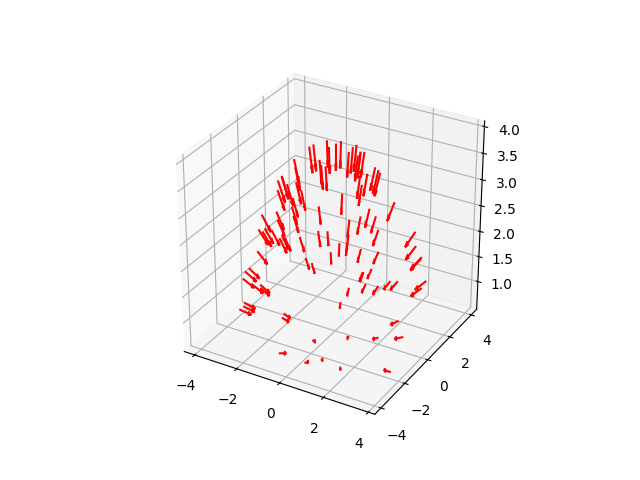

In [8]:
%matplotlib widget
# make three d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")

ax.quiver(
    origins[:, 0],
    origins[:, 1],
    origins[:, 2],
    directions[:, 0],
    directions[:, 1],
    directions[:, 2],
    color='r', normalize=True, length=0.5
)

In [27]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Linear(60, 256), nn.ReLU(),
            *[*[nn.Linear(256, 256), nn.ReLU()] * 4],
        )
        self.block2 = nn.Sequential(
            nn.Linear(60 + 256, 256), 
            nn.ReLU(),
            nn.Linear(256, 256), 
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256 + 1)
        )
        self.block3 = nn.Sequential(
            nn.Linear(256 + 24, 128), 
            nn.ReLU(),
            nn.Linear(128, 3),
            nn.Sigmoid(),
        )

    def _positional_encoding(self, position, direction):
        L_1 = 10
        L_2 = 4

        position = [torch.sin((2 ** i) * torch.pi * position), torch.cos((2 ** i) * torch.pi * position) for i in range(L_1)]


    def forward(self, position, direction):


        x = self.block1(position)
        print(position.shape, x.shape)
        x = torch.cat([position, x], dim=-1)
        print(x.shape)

        x = self.block2(x)
        x, sigma = x[:, :-1], x[:, -1]
        sigma = torch.max(torch.tensor(1e-6), sigma)

        x = torch.cat([x, direction], dim=-1)

        x = self.block3(x)
        return x, sigma

m = Model()
m(torch.zeros(1, 60), torch.zeros(1, 24))
None

torch.Size([1, 60]) torch.Size([1, 256])
torch.Size([1, 316])


In [35]:
position = torch.ones(1, 1)
[*[torch.sin((2 ** i) * torch.pi * position), torch.cos((2 ** i) * torch.pi * position)] for i in range(10)]

SyntaxError: iterable unpacking cannot be used in comprehension (4016998921.py, line 2)